Current Notebook:
1. Copy V4
2. No Scaling only X 
3. Removing Initial Zero Demand values per series
4. Lag, Rolling & Stat Features
5. Sample Weights Added (Normal Revenue as Weights instead of Rolling Revenue)
6. Undersampling for zero demand in train only

More Ideas:
1. Outliers in Demand columns.. Remove those greater than some threshold

In [1]:
MODEL_VERSION = "08"
NUM_TIMESTEPS = 28
RUN_ON_SAMPLE = False
SAMPLE_SIZE = 500
SCALING = False

DROPOUT = 0.3
MIN_LR = 1e-5
MAX_LR = 1e-2
STEP_SIZE = 2
BATCH_SIZE = 5*1024
PREDICT_BATCH_SIZE = 10*1024
NUM_EPOCHS = [4, 28, 4]

MC_DROPOUT = False
MC_SAMPLES = 10 if MC_DROPOUT else 1

In [2]:
import os, sys, datetime, pickle, gc
from time import time, ctime
from pprint import pprint
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Conv1D, Conv2D, LSTM, Embedding, Dense, concatenate, TimeDistributed
from tensorflow.keras.layers import BatchNormalization, Dropout, Flatten, Reshape, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import RepeatVector, Lambda
from tensorflow.keras.backend import repeat_elements
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint

import tensorflow_addons as tfa
from tensorflow_addons.optimizers import TriangularCyclicalLearningRate
from tensorflow_addons.losses import PinballLoss

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [4]:
seeded_value = 88888
pd.set_option('display.max_colwidth', 50)
np.random.seed(seeded_value)
tf.random.set_seed(seeded_value)

In [5]:
# suppress scientific notation
pd.options.display.precision = 2
np.set_printoptions(suppress=True)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [6]:
print([
    tf.__version__
])

['2.2.0']


In [7]:
start_time = time()
start = datetime.now()
print(ctime(start_time))

Sun Jun 28 05:08:33 2020


### Files
1. calendar.csv - Contains information about the dates on which the products are sold.
2. sales_train_validation.csv - Contains the historical daily unit sales data per product and store [d_1 - d_1913]
3. sample_submission.csv - The correct format for submissions. Reference the Evaluation tab for more info.
4. sell_prices.csv - Contains information about the price of the products sold per store and date.
5. sales_train_evaluation.csv - Includes sales [d_1 - d_1941] (labels used for the Public leaderboard)

In [8]:
DATA_DIR = "../data/"
RESULTS_DIR = "../results/"
PICKLE_DIR = "../data/preprocessed/"

In [9]:
CARDINAL_VARS = ['state_id', 'store_id', 'cat_id', 'dept_id', 'item_id', 'id']

In [10]:
TRAIN_INDICES = np.arange(1, 1885 + 1) # Could use 1156 i.e. only 2 years of data
VALID_INDICES = np.arange(1886, 1913 + 1)
PUBLIC_INDICES = np.arange(1914, 1941 + 1)
PRIVATE_INDICES = np.arange(1942, 1969 + 1)

In [11]:
print(min(TRAIN_INDICES), max(TRAIN_INDICES), len(TRAIN_INDICES))
print(min(VALID_INDICES), max(VALID_INDICES), len(VALID_INDICES))
print(min(PUBLIC_INDICES), max(PUBLIC_INDICES), len(PUBLIC_INDICES))
print(min(PRIVATE_INDICES), max(PRIVATE_INDICES), len(PRIVATE_INDICES))

1 1885 1885
1886 1913 28
1914 1941 28
1942 1969 28


Read about memory management in pandas [here](https://pythonspeed.com/articles/pandas-load-less-data/)

In [12]:
def diff_w_first(x:pd.Series, lag:int):
    x1 = x[:lag]
    x2  = x.diff(lag)[lag:]
    return pd.concat([x1, x2])

In [13]:
def add_features(df, grouping_col, col, roll_sizes, lag_sizes):
    
    # per series
    df[col+"_mean_s"] = df.groupby(grouping_col)[col].transform("mean")
    df[col+"_std_s"] = df.groupby(grouping_col)[col].transform("std")
    df[col+"_min_s"] = df.groupby(grouping_col)[col].transform("min")
    df[col+"_max_s"] = df.groupby(grouping_col)[col].transform("max")
    df[col+"_scaled_s"] = (df[col] - df[col+"_mean_s"]) / df[col+"_std_s"]
    
    # rolling window per series
    for i in roll_sizes:
        j = str(i)
        df[col+"_mean_rs_"+j] = df.groupby(grouping_col)[col].rolling(window=i, min_periods=1).mean().reset_index(drop=True)
        df[col+"_min_rs_"+j] = df.groupby(grouping_col)[col].rolling(window=i, min_periods=1).min().reset_index(drop=True)
        df[col+"_max_rs_"+j] = df.groupby(grouping_col)[col].rolling(window=i, min_periods=1).max().reset_index(drop=True)
        df[col+"_std_rs_"+j] = df.groupby(grouping_col)[col].rolling(window=i, min_periods=1).std().reset_index(drop=True)
        df[col+"_std_rs_"+j] = df[col+"_std_rs_"+j].fillna(1e-3)
    
    # various lags
    for i in lag_sizes:
        j = str(i)
        df[col+"_lag_"+j] = df.groupby(grouping_col)[col].apply(lambda x: diff_w_first(x,i)).reset_index(drop=False)[col]
    
    return df

In [14]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [15]:
def read_data(infer_mode:bool=False):
    print('Reading files...')
    
    calendar = pd.read_csv('../data/calendar.csv').fillna("None")
    calendar = reduce_mem_usage(calendar)
    print('Calendar has {} rows and {} columns'.format(calendar.shape[0], calendar.shape[1]))
    
    sell_prices = pd.read_csv('../data/sell_prices.csv')
    sell_prices = reduce_mem_usage(sell_prices)
    print('Sell prices has {} rows and {} columns'.format(sell_prices.shape[0], sell_prices.shape[1]))
    
    sales = pd.read_csv('../data/sales_train_evaluation.csv')
    print('Sales train validation has {} rows and {} columns'.format(sales.shape[0], sales.shape[1]))
    sales[['d_'+str(i) for i in PRIVATE_INDICES]] = pd.DataFrame(np.zeros(shape=(sales.shape[0], len(PRIVATE_INDICES))))
    print('Sales train validation has {} rows and {} columns'.format(sales.shape[0], sales.shape[1]))
    
    submission = pd.read_csv('../data/sample_submission.csv')
    
    pprint({
        "calendar.shape" : calendar.shape,
        "sell_prices.shape" : sell_prices.shape,
        "sales.shape" : sales.shape,
        "submission.shape" : submission.shape
    })
    
    return calendar, sell_prices, sales, submission

In [16]:
def add_dateparts(calendar, datecolname):
    calendar["Date"] = pd.to_datetime(calendar[datecolname], format = ("%Y-%m-%d"))
    calendar["Year"] = calendar["Date"].dt.year.astype('int16')
    calendar["Quarter"] = calendar["Date"].dt.quarter
    calendar["Month"] = calendar["Date"].dt.month
    calendar["Week"] = calendar["Date"].dt.week
    calendar["Day"] = calendar["Date"].dt.day
    calendar["DOW"] = calendar["Date"].dt.dayofweek
    calendar = reduce_mem_usage(calendar)
    return calendar

In [17]:
def melt_join_fill(sales, calendar, sell_prices):
    print("[INFO] ", "Starting  -- COMPLETE", ctime(time()))
    if RUN_ON_SAMPLE:
        sales = pd.melt(sales.sample(SAMPLE_SIZE),
                        id_vars=CARDINAL_VARS,
                        value_vars=Y_VARS,
                        var_name="day_id",
                        value_name='demand')
    else:
        sales = pd.melt(sales,
                        id_vars=CARDINAL_VARS,
                        value_vars=Y_VARS,
                        var_name="day_id",
                        value_name='demand')
    print("[INFO] ", "Melting  -- COMPLETE", ctime(time()))

    gc.collect()
    
    sales = pd.merge(sales, calendar, how="left", left_on="day_id", right_on="d")
    print("[INFO] ", "Merging1 -- COMPLETE", ctime(time()))
    
    gc.collect()
    
    sales = pd.merge(sales, sell_prices, how="left", on=["wm_yr_wk", "store_id", "item_id"])
    print("[INFO] ", "Merging2 -- COMPLETE", ctime(time()))
    
    gc.collect()
    
    # if sell_price is NA
    sales = sales.sort_values(by=CARDINAL_VARS+["date"])
    print("[INFO] ", "Sorting -- COMPLETE", ctime(time()))
    
    # remove till first non-zero demand per series
    before = sales.shape
    sales['cumul_demand'] = sales.groupby(['id'])['demand'].cumsum()
    sales = sales.loc[sales['cumul_demand']>0].copy().reset_index(drop=True)
    after = sales.shape
    print("[INFO] ", "Removal -- COMPLETE", ctime(time()))
    print("[INFO] ", "Removal", before, "--->", after)
    
    gc.collect()    
    
    sales["sell_price_available"] = np.where(sales.sell_price.isna(), "N", "Y")
    sales[["sell_price"]] = sales.groupby(["item_id"])[["sell_price"]].ffill()
    sales[["sell_price"]] = sales.groupby(["item_id"])[["sell_price"]].bfill()
    sales = sales.drop(["d", "wday", 'date', 'wm_yr_wk', 'weekday', 'month', 'year'], axis=1)
    
    sales['day_id'] = sales['day_id'].astype(str).apply(lambda x: x[2:]).astype(np.int16)
    
    print("[INFO] ", "Imputing -- COMPLETE", ctime(time()))    
    
    gc.collect()
    
    sales['weights'] = sales["sell_price"] * sales["demand"]
    sales['rolling_weights'] = sales.groupby(CARDINAL_VARS)['weights'].rolling(window=NUM_TIMESTEPS, min_periods=1).sum().reset_index(drop=True)
    
    sales['weights'] = sales['weights'].apply(lambda x: np.max((1.0, x)))
    sales['rolling_weights'] = sales['rolling_weights'].apply(lambda x: np.max((1.0, x)))
    
    print("[INFO] ", "Weighting -- COMPLETE", ctime(time()))    
    
    gc.collect()
    
    print("[INFO] ", "Final dataset contains", sales.shape)
    
    return sales.reset_index(drop=True)

In [18]:
MODEL_VERSION = "06"
if not os.path.exists(PICKLE_DIR+"merged_df_"+MODEL_VERSION+".pickle"):
    
    calendar, sell_prices, sales, submission = read_data()
    
    calendar = add_dateparts(calendar, "date")
    
    Y_VARS = sales.columns[sales.columns.str.startswith("d_")]

    data = melt_join_fill(sales, calendar, sell_prices)
    
    del sales, calendar, sell_prices
    gc.collect()

    data["demand_lag"] = data.groupby('id')['demand'].apply(lambda x: diff_w_first(x,60)).reset_index(drop=False)['demand']
    data = add_features(df=data, grouping_col="id", col="demand_lag", roll_sizes=[7, 30, 90, 365], lag_sizes=[7, 30, 90, 365])

    print("Saving all data to ---> ", PICKLE_DIR, "merged_df_"+MODEL_VERSION+".pickle")
    with open(os.path.join(PICKLE_DIR, "merged_df_"+MODEL_VERSION+".pickle"),"wb") as f:
        pickle.dump((data), f, protocol=4)
else:
    print("Pickle exists hence loading from pickle file ---> ", PICKLE_DIR, "merged_df_"+MODEL_VERSION+".pickle")
    with open(os.path.join(PICKLE_DIR+"merged_df_"+MODEL_VERSION+".pickle"), "rb") as f:
        data = pickle.load(f)

MODEL_VERSION = "08"

Pickle exists hence loading from pickle file --->  ../data/preprocessed/ merged_df_06.pickle


In [19]:
print(data.columns)

Index(['state_id', 'store_id', 'cat_id', 'dept_id', 'item_id', 'id', 'day_id',
       'demand', 'event_name_1', 'event_type_1', 'event_name_2',
       'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI', 'Date', 'Year',
       'Quarter', 'Month', 'Week', 'Day', 'DOW', 'sell_price', 'cumul_demand',
       'sell_price_available', 'weights', 'rolling_weights', 'demand_lag',
       'demand_lag_mean_s', 'demand_lag_std_s', 'demand_lag_min_s',
       'demand_lag_max_s', 'demand_lag_scaled_s', 'demand_lag_mean_rs_7',
       'demand_lag_min_rs_7', 'demand_lag_max_rs_7', 'demand_lag_std_rs_7',
       'demand_lag_mean_rs_30', 'demand_lag_min_rs_30', 'demand_lag_max_rs_30',
       'demand_lag_std_rs_30', 'demand_lag_mean_rs_90', 'demand_lag_min_rs_90',
       'demand_lag_max_rs_90', 'demand_lag_std_rs_90',
       'demand_lag_mean_rs_365', 'demand_lag_min_rs_365',
       'demand_lag_max_rs_365', 'demand_lag_std_rs_365', 'demand_lag_lag_7',
       'demand_lag_lag_30', 'demand_lag_lag_90', 'demand_lag_l

In [20]:
1913-28, 1913, 1913 + 28, 1913 + 28 + 28

(1885, 1913, 1941, 1969)

In [21]:
data.Date.min(), data.Date.max()#, data.Date.max() + 28, data.Date.max() + 28 + 28

(Timestamp('2011-01-29 00:00:00'), Timestamp('2016-06-19 00:00:00'))

In [22]:
print(data.shape); data.head()

(47649940, 53)


,state_id,store_id,cat_id,dept_id,item_id,id,day_id,demand,event_name_1,event_type_1,...,demand_lag_max_rs_90,demand_lag_std_rs_90,demand_lag_mean_rs_365,demand_lag_min_rs_365,demand_lag_max_rs_365,demand_lag_std_rs_365,demand_lag_lag_7,demand_lag_lag_30,demand_lag_lag_90,demand_lag_lag_365
0,CA,CA_1,FOODS,FOODS_1,FOODS_1_001,FOODS_1_001_CA_1_evaluation,1,3.00,None,None,...,3.00,0.00,3.00,3.00,3.00,0.00,3.00,3.00,3.00,3.00
1,CA,CA_1,FOODS,FOODS_1,FOODS_1_001,FOODS_1_001_CA_1_evaluation,2,0.00,None,None,...,3.00,2.12,1.50,0.00,3.00,2.12,0.00,0.00,0.00,0.00
2,CA,CA_1,FOODS,FOODS_1,FOODS_1_001,FOODS_1_001_CA_1_evaluation,3,0.00,None,None,...,3.00,1.73,1.00,0.00,3.00,1.73,0.00,0.00,0.00,0.00
3,CA,CA_1,FOODS,FOODS_1,FOODS_1_001,FOODS_1_001_CA_1_evaluation,4,1.00,None,None,...,3.00,1.41,1.00,0.00,3.00,1.41,1.00,1.00,1.00,1.00
4,CA,CA_1,FOODS,FOODS_1,FOODS_1_001,FOODS_1_001_CA_1_evaluation,5,4.00,None,None,...,4.00,1.82,1.60,0.00,4.00,1.82,4.00,4.00,4.00,4.00


# Preprocessing

In [23]:
CONT_VARS = ['snap_CA', 'snap_TX', 'snap_WI', 'sell_price',
             'demand_lag', 'demand_lag_mean_s', 'demand_lag_std_s', 'demand_lag_min_s',
             'demand_lag_max_s', 'demand_lag_scaled_s', 'demand_lag_mean_rs_7',
             'demand_lag_min_rs_7', 'demand_lag_max_rs_7', 'demand_lag_std_rs_7',
             'demand_lag_mean_rs_30', 'demand_lag_min_rs_30', 'demand_lag_max_rs_30',
             'demand_lag_std_rs_30', 'demand_lag_mean_rs_90', 'demand_lag_min_rs_90',
             'demand_lag_max_rs_90', 'demand_lag_std_rs_90', 'demand_lag_mean_rs_365',
             'demand_lag_min_rs_365', 'demand_lag_max_rs_365', 'demand_lag_std_rs_365',
             'demand_lag_lag_7', 'demand_lag_lag_30', 'demand_lag_lag_90', 'demand_lag_lag_365']
CAT_VARS = ['state_id', 'store_id', 'cat_id', 'dept_id', 'item_id', 'event_name_1',
            'event_type_1', 'event_name_2', 'event_type_2', 'Year', 'Quarter',
            'Month', 'Week', 'Day', 'DOW', 'sell_price_available']
DEP_VAR = ['demand']
WEIGHT_VAR = ['weights', 'rolling_weights']

## Sampling

In [24]:
data['set'] = np.where(data.day_id.isin(TRAIN_INDICES), "Train",
                       np.where(data.day_id.isin(VALID_INDICES), "Valid",
                                np.where(data.day_id.isin(PUBLIC_INDICES), "Public", "Private")))

In [25]:
data.groupby('set').agg({
    'id':'count',
    'day_id':[np.min, np.max]
})

id day_id      
            count   amin  amax
set                           
Private    853720   1942  1969
Public     853720   1914  1941
Train    45088780      1  1885
Valid      853720   1886  1913

In [26]:
data = data.drop(data[(data['set'] == "Train") & (data['demand'] == 0)].sample(frac=0.7).index).copy().reset_index()
gc.collect()

print("[INFO] ", "Sampling -- COMPLETE", ctime(time()))
print("[INFO] ", "Sampling --  ", data.shape)

[INFO]  Sampling -- COMPLETE Sun Jun 28 05:10:56 2020
[INFO]  Sampling --   (28811705, 55)


In [27]:
data[data['set'] == "Train"].groupby(['demand'])[['id']].count()

,id
demand,
0.00,8073529
1.00,7589986
2.00,3814220
3.00,2056171
4.00,1254448
...,...
634.00,1
648.00,1
693.00,1


### Categorical Data

In [28]:
Category_Mapping = {}
for c in CAT_VARS:
    # convert columns to categories
    data[c+"_cat"] = data[c].astype("category")
    
    # save the mapping for later use
    Category_Mapping.update({c+"_cat" : dict(enumerate(data[c+"_cat"].cat.categories))})
    
    # Copy categories as integer codes
    data[c+"_cat"] = data[c+"_cat"].cat.codes

In [29]:
Unique_Dict ={}
for c in CAT_VARS:
    col = c+"_cat"
    Unique_Dict.update({col:{'min':data[col].min(), 
                             'max':data[col].max(), 
                             'nuniq':data[col].nunique(), 
                             'emb_sz':max(min(int(data[col].nunique() / 2), 10), 2)}})
pprint(Unique_Dict)

{'DOW_cat': {'emb_sz': 3, 'max': 6, 'min': 0, 'nuniq': 7},
 'Day_cat': {'emb_sz': 10, 'max': 30, 'min': 0, 'nuniq': 31},
 'Month_cat': {'emb_sz': 6, 'max': 11, 'min': 0, 'nuniq': 12},
 'Quarter_cat': {'emb_sz': 2, 'max': 3, 'min': 0, 'nuniq': 4},
 'Week_cat': {'emb_sz': 10, 'max': 52, 'min': 0, 'nuniq': 53},
 'Year_cat': {'emb_sz': 3, 'max': 5, 'min': 0, 'nuniq': 6},
 'cat_id_cat': {'emb_sz': 2, 'max': 2, 'min': 0, 'nuniq': 3},
 'dept_id_cat': {'emb_sz': 3, 'max': 6, 'min': 0, 'nuniq': 7},
 'event_name_1_cat': {'emb_sz': 10, 'max': 30, 'min': 0, 'nuniq': 31},
 'event_name_2_cat': {'emb_sz': 2, 'max': 4, 'min': 0, 'nuniq': 5},
 'event_type_1_cat': {'emb_sz': 2, 'max': 4, 'min': 0, 'nuniq': 5},
 'event_type_2_cat': {'emb_sz': 2, 'max': 2, 'min': 0, 'nuniq': 3},
 'item_id_cat': {'emb_sz': 10, 'max': 3048, 'min': 0, 'nuniq': 3049},
 'sell_price_available_cat': {'emb_sz': 2, 'max': 0, 'min': 0, 'nuniq': 1},
 'state_id_cat': {'emb_sz': 2, 'max': 2, 'min': 0, 'nuniq': 3},
 'store_id_cat': {'e

In [30]:
NEW_CAT_VARS = [col+"_cat" for col in CAT_VARS]

### Numerical Data

In [31]:
if SCALING:
    MMS = MinMaxScaler()
    data[CONT_VARS] = MMS.fit_transform(data[CONT_VARS])
    
    MMS_Y = MinMaxScaler(feature_range=(0, 0.8))
    data[DEP_VAR] = MMS_Y.fit_transform(data[DEP_VAR])

# Cross Validation

In [32]:
train_data = data.loc[data.day_id.isin(TRAIN_INDICES)]
valid_data = data.loc[data.day_id.isin(VALID_INDICES)]
public_data = data.loc[data.day_id.isin(PUBLIC_INDICES)]
private_data = data.loc[data.day_id.isin(PRIVATE_INDICES)]
train_data.shape, valid_data.shape, public_data.shape, private_data.shape

((26250545, 71), (853720, 71), (853720, 71), (853720, 71))

In [33]:
data.shape[0] == train_data.shape[0] + valid_data.shape[0] + private_data.shape[0] + private_data.shape[0]

True

In [34]:
model_time = time()
model_t = datetime.now()
print(ctime(model_time))

Sun Jun 28 05:11:43 2020


# Model Specification

In [35]:
def build_model():
    layers = []
    inputs = []
    for i,col in enumerate(CAT_VARS):
        input_ = Input(shape=1, name=col+"_cat")
        embedding =  Embedding(Unique_Dict[col+"_cat"]['nuniq'],
                               Unique_Dict[col+"_cat"]['emb_sz'],
                               name='emb_'+col)(input_)
        vec = Flatten()(embedding)
        layers.append(vec)
        inputs.append(input_)
    
    for i, col in enumerate(CONT_VARS):
        input_ = Input(shape=1, name=col)
        layers.append(input_)
        inputs.append(input_)
    
    concat_layer = concatenate(layers)
    x = Dense(2048)(concat_layer)
    x = BatchNormalization()(x)
    x = Dropout(DROPOUT)(x, training=MC_DROPOUT)
    x = Activation('relu')(x)

    x = Dense(1024)(x)
    x = BatchNormalization()(x)
    x = Dropout(DROPOUT)(x, training=MC_DROPOUT)
    x = Activation('relu')(x)

    x = Dense(512)(x)
    x = BatchNormalization()(x)
    x = Dropout(DROPOUT)(x, training=MC_DROPOUT)
    x = Activation('relu')(x)
    
    x = Dense(256)(x)
    x = BatchNormalization()(x)
    x = Dropout(DROPOUT)(x, training=MC_DROPOUT)
    x = Activation('relu')(x)
    
    x = Dense(128)(x)
    x = BatchNormalization()(x)
    x = Dropout(DROPOUT)(x, training=MC_DROPOUT)
    x = Activation('relu')(x)
    
    x = Dense(64)(x)
    x = BatchNormalization()(x)
    x = Dropout(DROPOUT)(x, training=MC_DROPOUT)
    x = Activation('relu')(x)
    
    x = Dense(32)(x)
    x = Dropout(DROPOUT)(x, training=MC_DROPOUT)
    x = Activation('relu')(x)
    
    if SCALING:
        demand = Dense(1, activation='sigmoid', name='demand')(x)
    else:
        demand = Dense(1, activation='relu', name='demand')(x)
    
    model = Model(inputs, demand)
    
    return model

In [36]:
model = build_model()

In [37]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
state_id_cat (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
store_id_cat (InputLayer)       [(None, 1)]          0                                            
__________________________________________________________________________________________________
cat_id_cat (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
dept_id_cat (InputLayer)        [(None, 1)]          0                                            
______________________________________________________________________________________________

In [38]:
# if os.path.exists(RESULTS_DIR+"BestCheckpoint_"+MODEL_VERSION+".h5"):
#     model.load_weights(RESULTS_DIR+"BestCheckpoint_"+MODEL_VERSION+".h5")

In [39]:
tclr = TriangularCyclicalLearningRate(
    initial_learning_rate=MIN_LR,
    maximal_learning_rate=MAX_LR,
    step_size=STEP_SIZE * len(train_data)
)

In [40]:
mcp = ModelCheckpoint(filepath=RESULTS_DIR+"BestCheckpoint_"+MODEL_VERSION+".h5", monitor='val_loss',
                      verbose=0, save_best_only=True, save_weights_only=False, mode='min', save_freq='epoch')
csvl = CSVLogger(filename=RESULTS_DIR+"LossLogs_"+MODEL_VERSION+".csv",
                 separator=",", append=True)

In [41]:
PBL = PinballLoss(tau=[0.005,0.025,0.165,0.25,0.5,0.75,0.835,0.975,0.995])

In [42]:
adam = Adam(learning_rate=MAX_LR)
model.compile(loss= PBL if MC_DROPOUT else 'mse', optimizer=adam)

In [43]:
gc.collect()

20

In [44]:
history = model.fit(x=train_data[NEW_CAT_VARS + CONT_VARS].to_dict(orient='series'),
                    y=train_data[DEP_VAR].to_dict(orient='series'),
                    validation_data=(valid_data[NEW_CAT_VARS + CONT_VARS].to_dict(orient='series'),
                                     valid_data[DEP_VAR].to_dict(orient='series'),
                                     valid_data[WEIGHT_VAR].to_dict(orient='series')['weights']
                                    ),
                    batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS[0],
                    shuffle=True,
                    verbose=1,
                    sample_weight=train_data[WEIGHT_VAR].to_dict(orient='series')['weights'],
                    callbacks=[mcp, csvl])

Epoch 1/4
5128/5128 [==============================] - 418s 81ms/step - loss: 358.5001 - val_loss: 103.7809
Epoch 2/4
5128/5128 [==============================] - 416s 81ms/step - loss: 273.5926 - val_loss: 82.8077
Epoch 3/4
5128/5128 [==============================] - 414s 81ms/step - loss: 230.4289 - val_loss: 6873.1748
Epoch 4/4
5128/5128 [==============================] - 412s 80ms/step - loss: 218.5941 - val_loss: 489.4744


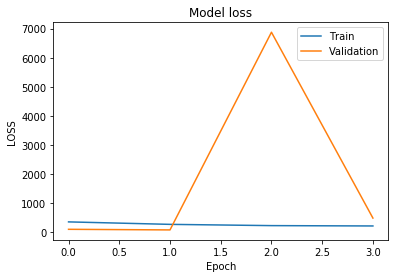

In [45]:
metric_names = ['loss']

for i, j in zip(metric_names, ['val_'+i for i in metric_names]):
    plt.plot(history.history[i])
    plt.plot(history.history[j])
    plt.title('Model '+i)
    plt.ylabel(i.upper())
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()

In [46]:
model = tf.keras.models.load_model(filepath=RESULTS_DIR+"BestCheckpoint_"+MODEL_VERSION+".h5", compile=False)

In [47]:
gc.collect()

20

In [48]:
adam = Adam(learning_rate=tclr)
model.compile(loss=PBL if MC_DROPOUT else 'mse', optimizer=adam)

In [49]:
history = model.fit(x=train_data[NEW_CAT_VARS + CONT_VARS].to_dict(orient='series'),
                    y=train_data[DEP_VAR].to_dict(orient='series'),
                    validation_data=(valid_data[NEW_CAT_VARS + CONT_VARS].to_dict(orient='series'),
                                     valid_data[DEP_VAR].to_dict(orient='series'),
                                     valid_data[WEIGHT_VAR].to_dict(orient='series')['weights']
                                    ),
                    batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS[1],
                    shuffle=True,
                    verbose=1, 
                    sample_weight=train_data[WEIGHT_VAR].to_dict(orient='series')['weights'],
                    callbacks=[mcp, csvl])

Epoch 1/28
5128/5128 [==============================] - 418s 82ms/step - loss: 219.2350 - val_loss: 82.3393
Epoch 2/28
5128/5128 [==============================] - 416s 81ms/step - loss: 213.2733 - val_loss: 82.8134
Epoch 3/28
5128/5128 [==============================] - 418s 82ms/step - loss: 212.3837 - val_loss: 83.0504
Epoch 4/28
5128/5128 [==============================] - 415s 81ms/step - loss: 211.3760 - val_loss: 83.5576
Epoch 5/28
5128/5128 [==============================] - 417s 81ms/step - loss: 211.2296 - val_loss: 83.5318
Epoch 6/28
5128/5128 [==============================] - 415s 81ms/step - loss: 209.5628 - val_loss: 83.3450
Epoch 7/28
5128/5128 [==============================] - 416s 81ms/step - loss: 210.0670 - val_loss: 83.3361
Epoch 8/28
5128/5128 [==============================] - 416s 81ms/step - loss: 209.2731 - val_loss: 83.3349
Epoch 9/28
5128/5128 [==============================] - 416s 81ms/step - loss: 209.1813 - val_loss: 83.0965
Epoch 10/28
5128/5128 [=====

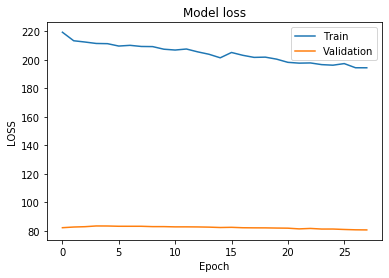

In [50]:
metric_names = ['loss']

for i, j in zip(metric_names, ['val_'+i for i in metric_names]):
    plt.plot(history.history[i])
    plt.plot(history.history[j])
    plt.title('Model ' + i)
    plt.ylabel(i.upper())
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()

In [51]:
model = tf.keras.models.load_model(filepath=RESULTS_DIR+"BestCheckpoint_"+MODEL_VERSION+".h5", compile=False)

In [52]:
gc.collect()

18910

In [53]:
adam = Adam(learning_rate=MIN_LR*0.1)
model.compile(loss=PBL if MC_DROPOUT else 'mse', optimizer=adam)

In [54]:
history = model.fit(x=train_data[NEW_CAT_VARS + CONT_VARS].to_dict(orient='series'),
                    y=train_data[DEP_VAR].to_dict(orient='series'),
                    validation_data=(valid_data[NEW_CAT_VARS + CONT_VARS].to_dict(orient='series'),
                                     valid_data[DEP_VAR].to_dict(orient='series'),
                                     valid_data[WEIGHT_VAR].to_dict(orient='series')['weights']
                                    ),
                    batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS[2],
                    shuffle=True,
                    verbose=1, 
                    sample_weight=train_data[WEIGHT_VAR].to_dict(orient='series')['weights'],
                    callbacks=[mcp, csvl])

Epoch 1/4
5128/5128 [==============================] - 416s 81ms/step - loss: 193.9020 - val_loss: 80.5856
Epoch 2/4
5128/5128 [==============================] - 415s 81ms/step - loss: 192.6692 - val_loss: 80.7848
Epoch 3/4
5128/5128 [==============================] - 415s 81ms/step - loss: 193.4968 - val_loss: 80.7026
Epoch 4/4
5128/5128 [==============================] - 415s 81ms/step - loss: 193.5206 - val_loss: 80.7557


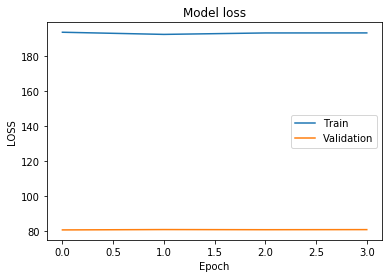

In [55]:
metric_names = ['loss']

for i, j in zip(metric_names, ['val_'+i for i in metric_names]):
    plt.plot(history.history[i])
    plt.plot(history.history[j])
    plt.title('Model '+i)
    plt.ylabel(i.upper())
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'])
    plt.show()

In [56]:
model.save(filepath=RESULTS_DIR+"FinalCheckpoint_"+MODEL_VERSION+".h5", overwrite=True)

# Validation

In [57]:
if os.path.exists(RESULTS_DIR+"BestCheckpoint_"+MODEL_VERSION+".h5"):
    model = tf.keras.models.load_model(filepath=RESULTS_DIR+"BestCheckpoint_"+MODEL_VERSION+".h5", compile=False)

In [58]:
gc.collect()

15884

In [59]:
for i in range(MC_SAMPLES):
    if i == 0:
        train_preds = model.predict(train_data[NEW_CAT_VARS + CONT_VARS].to_dict(orient='series'),
                                    batch_size=PREDICT_BATCH_SIZE, verbose=0)

        valid_preds = model.predict(valid_data[NEW_CAT_VARS + CONT_VARS].to_dict(orient='series'),
                                    batch_size=PREDICT_BATCH_SIZE, verbose=0)

        public_preds = model.predict(public_data[NEW_CAT_VARS + CONT_VARS].to_dict(orient='series'),
                                     batch_size=PREDICT_BATCH_SIZE, verbose=0)

        private_preds = model.predict(private_data[NEW_CAT_VARS + CONT_VARS].to_dict(orient='series'),
                                      batch_size=PREDICT_BATCH_SIZE, verbose=0)
        
    else:
        train_preds = np.concatenate((train_preds, 
                                      model.predict(train_data[NEW_CAT_VARS + CONT_VARS].to_dict(orient='series'),
                                                    batch_size=PREDICT_BATCH_SIZE, verbose=0)), axis=1)

        valid_preds = np.concatenate((valid_preds, 
                                      model.predict(valid_data[NEW_CAT_VARS + CONT_VARS].to_dict(orient='series'),
                                                    batch_size=PREDICT_BATCH_SIZE, verbose=0)), axis=1)

        public_preds = np.concatenate((public_preds, 
                                       model.predict(public_data[NEW_CAT_VARS + CONT_VARS].to_dict(orient='series'),
                                                     batch_size=PREDICT_BATCH_SIZE, verbose=0)), axis=1)

        private_preds = np.concatenate((private_preds, 
                                        model.predict(private_data[NEW_CAT_VARS + CONT_VARS].to_dict(orient='series'),
                                                      batch_size=PREDICT_BATCH_SIZE, verbose=0)), axis=1)

print(train_preds.shape, valid_preds.shape, public_preds.shape, private_preds.shape)

(26250545, 1) (853720, 1) (853720, 1) (853720, 1)


In [60]:
gc.collect()

7927

In [61]:
if SCALING:
    train_demand = MMS_Y.inverse_transform(train_preds)
    valid_demand = MMS_Y.inverse_transform(valid_preds)
    public_demand = MMS_Y.inverse_transform(public_preds)
    private_demand = MMS_Y.inverse_transform(private_preds)
    
    data['prediction'] = 0
    data[['prediction']].loc[data.day_id.isin(TRAIN_INDICES)] = train_preds
    data[['prediction']].loc[data.day_id.isin(VALID_INDICES)] = valid_preds
    data[['prediction']].loc[data.day_id.isin(PUBLIC_INDICES)] = public_preds
    data[['prediction']].loc[data.day_id.isin(PRIVATE_INDICES)] = private_preds

    data['demand_Unscaled'] = MMS_Y.inverse_transform(data[['demand']])
    data[[col+'_Unscaled' for col in CONT_VARS]] = pd.DataFrame(MMS.inverse_transform(data[CONT_VARS]))

In [62]:
data['pred_demand'] = 0

if SCALING:
    data['pred_demand'].loc[data.day_id.isin(TRAIN_INDICES)] = train_demand.flatten()
    data['pred_demand'].loc[data.day_id.isin(VALID_INDICES)] = valid_demand.flatten()
    data['pred_demand'].loc[data.day_id.isin(PUBLIC_INDICES)] = public_demand.flatten()
    data['pred_demand'].loc[data.day_id.isin(PRIVATE_INDICES)] = private_demand.flatten()
else:
    data['pred_demand'].loc[data.day_id.isin(TRAIN_INDICES)] = train_preds.flatten()
    data['pred_demand'].loc[data.day_id.isin(VALID_INDICES)] = valid_preds.flatten()
    data['pred_demand'].loc[data.day_id.isin(PUBLIC_INDICES)] = public_preds.flatten()
    data['pred_demand'].loc[data.day_id.isin(PRIVATE_INDICES)] = private_preds.flatten()

/anaconda/envs/py37_tensorflow/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [63]:
gc.collect()

40

In [64]:
for i in ['Train', 'Valid', 'Public', 'Private']:
    print(i)
    print('\t',{
        i+'_RMSE' : np.round(mean_squared_error(y_true = data['demand'].loc[data.set == i],
                                                y_pred = data['pred_demand'].loc[data.set == i]),
                             2) if i!='Private' else 'None',
        i+"_REAL_SUM" : np.round(data['demand'].loc[data.set != i].sum(), 2),
        i+"_PRED_SUM" : np.round(data['pred_demand'].loc[data.set != i].sum(), 2),
    })

Train
	 {'Train_RMSE': 7.27, 'Train_REAL_SUM': 2415390.0, 'Train_PRED_SUM': 6149849.43}
Valid
	 {'Valid_RMSE': 5.24, 'Valid_REAL_SUM': 65743547.0, 'Valid_PRED_SUM': 94539353.25}
Public
	 {'Public_RMSE': 5.07, 'Public_REAL_SUM': 65695409.0, 'Public_PRED_SUM': 94510194.48}
Private
	 {'Private_RMSE': 'None', 'Private_REAL_SUM': 66927173.0, 'Private_PRED_SUM': 94969668.91}


In [65]:
# Is the distribution same?
data[['demand','pred_demand','set']].groupby('set').describe()

demand                                      pred_demand       \
              count mean  std  min  25%  50%  75%    max       count mean   
set                                                                         
Private   853720.00 0.00 0.00 0.00 0.00 0.00 0.00   0.00   853720.00 2.05   
Public    853720.00 1.44 3.64 0.00 0.00 0.00 2.00 196.00   853720.00 2.59   
Train   26250545.00 2.46 5.44 0.00 0.00 1.00 3.00 763.00 26250545.00 3.45   
Valid     853720.00 1.39 3.59 0.00 0.00 0.00 1.00 204.00   853720.00 2.56   

                                         
         std  min  25%  50%  75%    max  
set                                      
Private 2.83 0.61 0.98 1.27 2.05 141.42  
Public  3.81 0.61 1.05 1.49 2.68 182.17  
Train   5.61 0.60 1.18 1.88 3.61 898.29  
Valid   3.70 0.61 1.05 1.48 2.65 193.47

## Submission

In [66]:
submission = data.loc[data['set'].isin(['Private', 'Public'])][['id',
                                                                'day_id',
                                                                'pred_demand', 
                                                                'set']].copy().reset_index(drop=True)

In [67]:
submission['day_id2'] = 'F' + pd.Series(np.where(submission['day_id'] <= max(PUBLIC_INDICES), 
                                                 submission['day_id'] - min(PUBLIC_INDICES) + 1, 
                                                 submission['day_id'] - min(PRIVATE_INDICES) + 1).astype(int).astype(str))

In [68]:
submission['id'] = np.where(submission['set']=="Public",
                            submission['id'].str.replace("evaluation", "validation"), 
                            submission['id'])

In [69]:
submission.groupby('set').agg({
    'day_id':[np.min, np.max]
})

day_id      
          amin  amax
set                 
Private   1942  1969
Public    1914  1941

In [70]:
submission_file = submission.pivot(
    values='pred_demand',
    index='id',
    columns='day_id2').reset_index(drop=False)
submission_file = submission_file[['id']+["F"+str(i) for i in range(1,29,1)]]

In [71]:
submission_file.head()

day_id2,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_evaluation,1.61,1.39,1.43,1.70,1.14,1.48,1.55,1.62,0.79,...,1.28,1.81,1.60,1.44,1.89,1.29,1.88,0.86,1.49,1.41
1,FOODS_1_001_CA_1_validation,1.88,1.33,1.53,1.37,1.19,2.22,1.74,1.69,5.46,...,1.52,3.71,2.51,1.17,1.39,1.22,1.47,1.80,1.20,1.17
2,FOODS_1_001_CA_2_evaluation,1.67,1.63,1.26,1.47,1.68,1.69,1.77,1.68,1.77,...,1.77,1.72,1.35,1.96,1.67,2.00,0.63,1.88,1.55,1.49
3,FOODS_1_001_CA_2_validation,1.60,2.70,1.76,1.55,1.72,1.78,2.66,1.43,1.79,...,1.25,1.45,1.66,2.22,2.10,1.79,1.32,1.93,2.65,1.71
4,FOODS_1_001_CA_3_evaluation,1.82,1.96,0.80,2.25,2.47,2.12,1.84,2.49,2.48,...,2.03,2.40,2.39,2.41,2.44,2.52,0.86,2.29,2.22,2.26


In [72]:
submission_file.tail()

day_id2,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
60975,HOUSEHOLD_2_516_WI_1_validation,1.25,0.70,0.71,1.31,0.71,0.64,0.82,0.76,0.76,...,0.79,0.83,0.82,0.79,0.81,0.65,0.79,1.49,0.79,0.79
60976,HOUSEHOLD_2_516_WI_2_evaluation,0.87,0.86,0.84,0.83,0.80,0.84,0.87,0.71,0.82,...,0.81,0.89,0.92,0.86,0.87,0.89,0.84,0.85,0.86,0.87
60977,HOUSEHOLD_2_516_WI_2_validation,0.78,0.63,0.76,0.77,0.81,0.80,0.86,0.81,0.81,...,0.83,0.89,1.96,2.09,0.85,0.83,0.82,0.83,0.80,0.79
60978,HOUSEHOLD_2_516_WI_3_evaluation,0.96,0.94,0.94,0.92,0.89,0.95,0.95,0.75,0.90,...,0.91,0.96,0.98,0.93,0.98,0.97,0.93,0.95,0.95,0.95
60979,HOUSEHOLD_2_516_WI_3_validation,0.82,0.81,0.84,0.66,1.46,0.91,0.94,0.89,0.87,...,0.68,1.41,0.99,0.94,0.95,0.96,0.92,0.95,0.88,0.89


In [73]:
submission_file.to_csv('../results/submission_'+MODEL_VERSION+'.csv', index=False)

In [74]:
end_time = time()
end = datetime.now()
print(ctime(end_time))
print(end - start, model_t - start, end - model_t)

Sun Jun 28 09:24:56 2020
4:16:22.674947 0:03:09.563170 4:13:13.111777
